In [94]:
import os

import pandas as pd
import numpy as np
import geopandas as gpd 
import rasterio 
from rasterio.plot import  show, adjust_band
from rasterio.mask import mask
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings 
from os import listdir

warnings = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from visualisation_scripts import get_maps

In [3]:
archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')
archangelskiy_cameral = pd.read_csv('points_gps/cameral_crc.csv', encoding = "ANSI", sep =';')
archangelskiy_cameral = archangelskiy_cameral[['name', '%']].groupby('name').mean().reset_index()
archangelskiy_cameral.columns = ['type' , 'perc [%] камеральный']

archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')

archangelskiy['вес'] =archangelskiy['вес'] - archangelskiy['тара']
archangelskiy['вес [ц/га]'] = archangelskiy['вес'] * 4 * (10000) / 1000 / 100
archangelskiy = archangelskiy[['точка', '%', 'вес [ц/га]']]
archangelskiy = archangelskiy.groupby('точка').mean().reset_index()
archangelskiy.columns = ['type', 'perc [%] полевой',"вес [ц/га] полевой" ]
archangelskiy = archangelskiy.merge(archangelskiy_cameral, on = 'type', how = 'outer')
archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный
0,525,62.50,21.4,82.000000
1,526,81.25,41.5,89.714286
2,527,68.75,32.5,96.857143
3,528,68.75,24.0,80.285714
4,586,96.75,62.4,87.142857
5,587,43.75,38.9,30.000000
6,588,33.75,27.4,30.571429


In [4]:
archangelskiy_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
archangelskiy_points.columns = ['type',"geometry" ]
archangelskiy_points

,type,geometry
0,525,POINT Z (44.18418 44.55136 170.78041)
1,526,POINT Z (44.18086 44.54805 167.81140)
2,527,POINT Z (44.17407 44.54223 164.98230)
3,528,POINT Z (44.16865 44.54459 169.67947)
4,529,POINT Z (44.16700 44.53811 175.87118)
5,585,POINT Z (44.16801 44.53532 172.00731)
6,586,POINT Z (44.17582 44.54182 160.97470)
7,587,POINT Z (44.18650 44.54988 162.74657)
8,588,POINT Z (44.18876 44.54880 163.77283)


In [176]:
minNDTi_raster = rasterio.open('raster_data/achangelskoe_minNDTI_2021.tif')
minNDTI = minNDTi_raster.read()[0]

NDTI_at_moment = rasterio.open('raster_data/Field_scale_sentinel2_2021-09-21_scene.tif')
NDVI_at_moment_array = NDTI_at_moment.read()[6]
NDTI_at_monent_array = NDTI_at_moment.read()[7]

NDTI = NDTI_at_monent_array.copy()

NDTI[NDVI_at_moment_array >= 0.3] = np.nan

NDVI_mask = (NDVI_at_moment_array >= 0.3).astype('int')


metadata = minNDTi_raster.meta

[Text(0.5, 1.0, 'minNDTI\n2021-07-15 - 2021-10-15')]

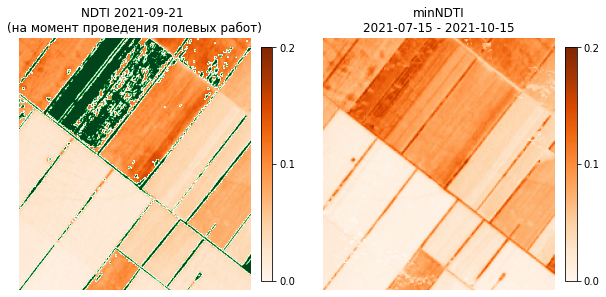

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,10)) 

NDTI_hiden_layer = axes[0].imshow(NDVI_mask, cmap='Greens')
NDTI_vis = axes[0].imshow(NDTI, cmap='Oranges')
NDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
fig.colorbar(NDTI_vis, fraction=0.046, pad=0.04, ax=axes[0]).set_ticks([ 0,0.1,0.2])
axes[0].axis('off')
axes[0].set(title = 'NDTI 2021-09-21 \n(на момент проведения полевых работ)')

minNDTI_vis = axes[1].imshow( minNDTI , cmap='Oranges')
minNDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
fig.colorbar(minNDTI_vis, fraction=0.046, pad=0.04, ax=axes[1]).set_ticks([ 0,0.1,0.2])
axes[1].axis('off')
axes[1].set(title = 'minNDTI\n2021-07-15 - 2021-10-15')

In [7]:
def RC_cover(x):
    rc = (m * x) + b 
    return(rc)

"""функция для пересчета массивов"""

'функция для пересчета массивов'

In [8]:
# NDTI 
# +-3 std 
NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)]
top = NDTI_arr.mean() + (3 * NDTI_arr.std())
bottom = NDTI_arr.mean() - (3 * NDTI_arr.std())
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_std_method = RC_cover(NDTI)



# NDTI 
# min_max 
NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)]
top = np.max(NDTI_arr)
bottom = np.min(NDTI_arr)
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_min_max_method = RC_cover(NDTI)


In [9]:
# minNDTI 
# +-3 std 
minNDTI_arr = minNDTI.reshape(-1)
minNDTI_arr = minNDTI_arr[~np.isnan(minNDTI_arr)]
top = minNDTI_arr.mean() + (3 * minNDTI_arr.std())
bottom = minNDTI_arr.mean() - (3 * minNDTI_arr.std())
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_minNDTI_std_method = RC_cover(minNDTI)

# minNDTI 
# min_max 
minNDTI_arr = minNDTI.reshape(-1)
minNDTI_arr = minNDTI_arr[~np.isnan(minNDTI_arr)]
top = np.max(minNDTI_arr)
bottom = np.min(minNDTI_arr)
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_minNDTI_min_max_method = RC_cover(minNDTI)

In [10]:
rasters_dict = {'NDTI в моменте' : NDTI,
                "minNDTI" : minNDTI,
                "имперический NDTI +-3 стнд.откл" : imperic_crc_std_method,
                'имперический NDTI мин/макс' : imperic_crc_min_max_method,
                'имперический minNDTI +-3 стнд.откл' : imperic_crc_minNDTI_std_method,
                "имперический minNDTI мин/макс" : imperic_crc_minNDTI_min_max_method}


def extract_values_to_points(raster,points_df):
    X_ = points_df.to_crs(metadata['crs']).geometry.x
    Y_ = points_df.to_crs(metadata['crs']).geometry.y
    points_dict ={}
    for i in range(len(points_df['type'])):
        ind = (minNDTi_raster.index(X_[i],Y_[i]))
        points_dict[points_df['type'][i]] = raster[ind[0], ind[1]]
    df = pd.DataFrame.from_dict(points_dict, orient='index',).reset_index()
    return(df)

for method in rasters_dict.keys():
    df = extract_values_to_points(rasters_dict[method],archangelskiy_points)
    df.columns = ["type", method]
    df['type'] = df['type'].astype('int64')
    archangelskiy = archangelskiy.merge(df, on = 'type', how = 'outer')

archangelskiy = archangelskiy.fillna(value = 0)

archangelskiy

    

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный,NDTI в моменте,minNDTI,имперический NDTI +-3 стнд.откл,имперический NDTI мин/макс,имперический minNDTI +-3 стнд.откл,имперический minNDTI мин/макс
0,525,62.50,21.4,82.000000,0.121709,0.102655,0.729161,0.610803,0.642874,0.693995
1,526,81.25,41.5,89.714286,0.115793,0.100361,0.704579,0.580027,0.634171,0.687048
2,527,68.75,32.5,96.857143,0.130336,0.099514,0.765008,0.655682,0.630958,0.684483
3,528,68.75,24.0,80.285714,0.099462,0.082840,0.636720,0.495070,0.567708,0.633994
4,586,96.75,62.4,87.142857,0.131532,0.116338,0.769976,0.661902,0.694779,0.735428
5,587,43.75,38.9,30.000000,0.049634,0.049634,0.429673,0.235853,0.441742,0.533443
6,588,33.75,27.4,30.571429,0.039044,0.039044,0.385671,0.180765,0.401572,0.501377
7,529,0.00,0.0,0.000000,0.022754,0.009025,0.317983,0.096021,0.287696,0.410477
8,585,0.00,0.0,0.000000,0.019031,0.007214,0.302511,0.076651,0.280826,0.404993


<AxesSubplot:>

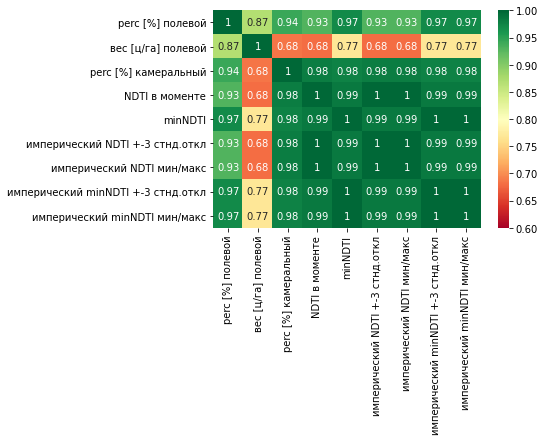

In [11]:
sns.heatmap(archangelskiy.iloc[:,1:].corr(), vmin=0.6 , vmax=1, annot=True, cmap = 'RdYlGn')

In [12]:
kursk = pd.read_csv('points_gps/kursk_crc.csv', encoding=  'ANSI', sep = ';')
kursk['вес'] = kursk['вес'] - kursk['тара ']
kursk['вес'] = kursk['вес'] * 4 * (10000) / 1000 / 100 
kursk = kursk[['точка', "вес", '%']]
kursk.columns = ['type',"вес [ц/га] полевой", 'perc [%] полевой' ]
kursk

,type,вес [ц/га] полевой,perc [%] полевой
0,543,27.6,80
1,542,34.4,40
2,541,18.8,40
3,540,14.4,60
4,539,36.8,70
5,40,31.2,90
6,41,40.0,90
7,42,46.0,80
8,43,20.4,60
9,44,17.2,80


In [13]:
kursk_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
kursk_points.columns = ['type',"geometry" ]
kursk_points

,type,geometry
0,525,POINT Z (44.18418 44.55136 170.78041)
1,526,POINT Z (44.18086 44.54805 167.81140)
2,527,POINT Z (44.17407 44.54223 164.98230)
3,528,POINT Z (44.16865 44.54459 169.67947)
4,529,POINT Z (44.16700 44.53811 175.87118)
5,585,POINT Z (44.16801 44.53532 172.00731)
6,586,POINT Z (44.17582 44.54182 160.97470)
7,587,POINT Z (44.18650 44.54988 162.74657)
8,588,POINT Z (44.18876 44.54880 163.77283)


In [14]:
kursk_points = gpd.read_file('points_gps/kursk_points.geojson')[['name', 'geometry']]
kursk_points.columns = ['type',"geometry" ]
kursk_points

,type,geometry
0,040,POINT Z (36.26295 51.62984 204.49696)
1,041,POINT Z (36.26260 51.62984 202.89212)
2,042,POINT Z (36.26231 51.62984 198.45747)
3,043,POINT Z (36.26202 51.62988 198.19040)
4,044,POINT Z (36.26145 51.62989 204.41188)
5,480,POINT Z (36.26004 51.62996 203.20254)
6,481,POINT Z (36.26034 51.62994 201.38284)
7,482,POINT Z (36.26068 51.62995 201.38208)
8,484,POINT Z (36.26096 51.62992 203.14285)
9,485,POINT Z (36.26123 51.62990 202.19731)


In [15]:
minNDTi_raster = rasterio.open('raster_data/kursk/minNDTI_kursk.tif')
minNDTI = minNDTi_raster.read()[0]

NDTI_at_moment = rasterio.open('raster_data/kursk/2021-08-29.tif')
NDVI_at_moment_array = NDTI_at_moment.read()[6]
NDTI_at_monent_array = NDTI_at_moment.read()[7]

NDTI = NDTI_at_monent_array.copy()

NDTI[NDVI_at_moment_array >= 0.35] = np.nan

NDVI_mask = (NDVI_at_moment_array >= 0.35).astype('int')


metadata = minNDTi_raster.meta

[Text(0.5, 1.0, 'minNDTI\n2021-07-15 - 2021-10-15')]

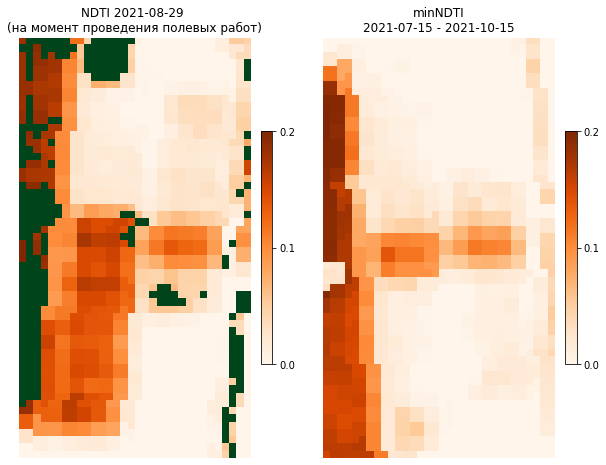

In [16]:
fig, axes = plt.subplots(1,2, figsize=(10,10)) 

NDTI_hiden_layer = axes[0].imshow(NDVI_mask, cmap='Greens')
NDTI_vis = axes[0].imshow(NDTI, cmap='Oranges')
NDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
fig.colorbar(NDTI_vis, fraction=0.046, pad=0.04, ax=axes[0]).set_ticks([ 0,0.1,0.2])
axes[0].axis('off')
axes[0].set(title = 'NDTI 2021-08-29 \n(на момент проведения полевых работ)')

minNDTI_vis = axes[1].imshow( minNDTI , cmap='Oranges')
minNDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
fig.colorbar(minNDTI_vis, fraction=0.046, pad=0.04, ax=axes[1]).set_ticks([ 0,0.1,0.2])
axes[1].axis('off')
axes[1].set(title = 'minNDTI\n2021-07-15 - 2021-10-15')

In [17]:
# NDTI 
# +-3 std 
NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)]
top = NDTI_arr.mean() + (3 * NDTI_arr.std())
bottom = NDTI_arr.mean() - (3 * NDTI_arr.std())
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_std_method = RC_cover(NDTI)



# NDTI 
# min_max 
NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)]
top = np.max(NDTI_arr)
bottom = np.min(NDTI_arr)
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_min_max_method = RC_cover(NDTI)



In [18]:
# minNDTI 
# +-3 std 
minNDTI_arr = minNDTI.reshape(-1)
minNDTI_arr = minNDTI_arr[~np.isnan(minNDTI_arr)]
top = minNDTI_arr.mean() + (3 * minNDTI_arr.std())
bottom = minNDTI_arr.mean() - (3 * minNDTI_arr.std())
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_minNDTI_std_method = RC_cover(minNDTI)

# minNDTI 
# min_max 
minNDTI_arr = minNDTI.reshape(-1)
minNDTI_arr = minNDTI_arr[~np.isnan(minNDTI_arr)]
top = np.max(minNDTI_arr)
bottom = np.min(minNDTI_arr)
m = (0.95 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_minNDTI_min_max_method = RC_cover(minNDTI)

In [19]:
rasters_dict = {'NDTI в моменте' : NDTI,
                "minNDTI" : minNDTI,
                "имперический NDTI +-3 стнд.откл" : imperic_crc_std_method,
                'имперический NDTI мин/макс' : imperic_crc_min_max_method,
                'имперический minNDTI +-3 стнд.откл' : imperic_crc_minNDTI_std_method,
                "имперический minNDTI мин/макс" : imperic_crc_minNDTI_min_max_method}

for method in rasters_dict.keys():
    df = extract_values_to_points(rasters_dict[method],kursk_points)
    df.columns = ["type", method]
    df['type'] = df['type'].astype('int64')
    kursk = kursk.merge(df, on = 'type', how = 'outer')

kursk = kursk.fillna(value = 0)
kursk

,type,вес [ц/га] полевой,perc [%] полевой,NDTI в моменте,minNDTI,имперический NDTI +-3 стнд.откл,имперический NDTI мин/макс,имперический minNDTI +-3 стнд.откл,имперический minNDTI мин/макс
0,543,27.6,80.0,0.012618,0.031038,0.373955,0.217139,0.466379,0.298381
1,542,34.4,40.0,0.028789,0.035162,0.414030,0.276357,0.477059,0.314215
2,541,18.8,40.0,0.026084,0.018509,0.407327,0.266452,0.433933,0.250278
3,540,14.4,60.0,0.024109,0.023511,0.402434,0.259221,0.446887,0.269484
4,539,36.8,70.0,0.024658,0.017021,0.403792,0.261228,0.430078,0.244564
5,40,31.2,90.0,-0.000947,0.008588,0.340339,0.167464,0.408241,0.212190
6,41,40.0,90.0,0.124166,0.103511,0.650393,0.625629,0.654066,0.576637
7,42,46.0,80.0,0.127510,0.107660,0.658680,0.637874,0.664809,0.592564
8,43,20.4,60.0,0.137165,0.113882,0.682604,0.673227,0.680923,0.616454
9,44,17.2,80.0,0.083476,0.066597,0.549554,0.476620,0.558467,0.434907


<AxesSubplot:>

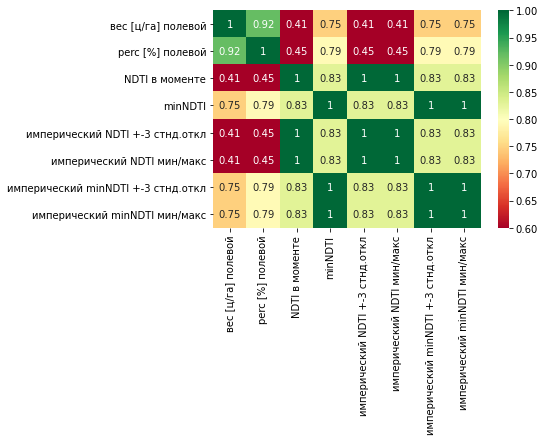

In [20]:
sns.heatmap(kursk.iloc[:,1:].corr(), vmin=0.6 , vmax=1, annot=True, cmap = 'RdYlGn')

<AxesSubplot:>

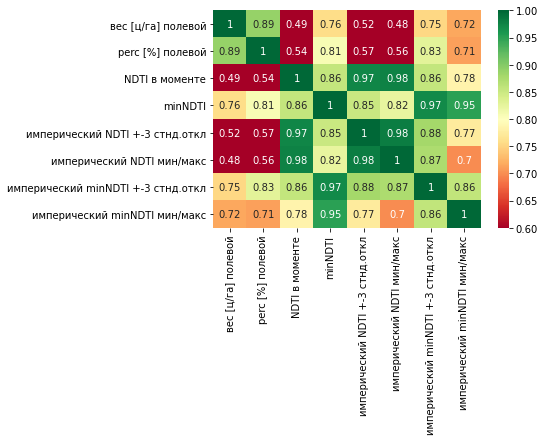

In [21]:
total_df = archangelskiy[kursk.columns].append(kursk)
sns.heatmap(total_df.iloc[:,1:].corr(), vmin=0.6 , vmax=1, annot=True, cmap = 'RdYlGn')

In [22]:
total_df

,type,вес [ц/га] полевой,perc [%] полевой,NDTI в моменте,minNDTI,имперический NDTI +-3 стнд.откл,имперический NDTI мин/макс,имперический minNDTI +-3 стнд.откл,имперический minNDTI мин/макс
0,525,21.4,62.50,0.121709,0.102655,0.729161,0.610803,0.642874,0.693995
1,526,41.5,81.25,0.115793,0.100361,0.704579,0.580027,0.634171,0.687048
2,527,32.5,68.75,0.130336,0.099514,0.765008,0.655682,0.630958,0.684483
3,528,24.0,68.75,0.099462,0.082840,0.636720,0.495070,0.567708,0.633994
4,586,62.4,96.75,0.131532,0.116338,0.769976,0.661902,0.694779,0.735428
5,587,38.9,43.75,0.049634,0.049634,0.429673,0.235853,0.441742,0.533443
6,588,27.4,33.75,0.039044,0.039044,0.385671,0.180765,0.401572,0.501377
7,529,0.0,0.00,0.022754,0.009025,0.317983,0.096021,0.287696,0.410477
8,585,0.0,0.00,0.019031,0.007214,0.302511,0.076651,0.280826,0.404993
0,543,27.6,80.00,0.012618,0.031038,0.373955,0.217139,0.466379,0.298381


In [23]:
archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный,NDTI в моменте,minNDTI,имперический NDTI +-3 стнд.откл,имперический NDTI мин/макс,имперический minNDTI +-3 стнд.откл,имперический minNDTI мин/макс
0,525,62.50,21.4,82.000000,0.121709,0.102655,0.729161,0.610803,0.642874,0.693995
1,526,81.25,41.5,89.714286,0.115793,0.100361,0.704579,0.580027,0.634171,0.687048
2,527,68.75,32.5,96.857143,0.130336,0.099514,0.765008,0.655682,0.630958,0.684483
3,528,68.75,24.0,80.285714,0.099462,0.082840,0.636720,0.495070,0.567708,0.633994
4,586,96.75,62.4,87.142857,0.131532,0.116338,0.769976,0.661902,0.694779,0.735428
5,587,43.75,38.9,30.000000,0.049634,0.049634,0.429673,0.235853,0.441742,0.533443
6,588,33.75,27.4,30.571429,0.039044,0.039044,0.385671,0.180765,0.401572,0.501377
7,529,0.00,0.0,0.000000,0.022754,0.009025,0.317983,0.096021,0.287696,0.410477
8,585,0.00,0.0,0.000000,0.019031,0.007214,0.302511,0.076651,0.280826,0.404993


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

In [25]:
X = litle_df["NDTI в моменте" ]
y = litle_df["perc [%] полевой"]

NameError: name 'litle_df' is not defined

In [ ]:
litle_df = archangelskiy[["NDTI в моменте","perc [%] полевой" ]]

In [213]:
litle_df.iloc[:,0]

0    0.121709
1    0.115793
2    0.130336
3    0.099462
4    0.131532
5    0.049634
6    0.039044
7    0.022754
8    0.019031
Name: NDTI в моменте, dtype: float64

In [266]:
def line_regression(df):
    """
    на вход df с двумя колонками - 1я по чему учимся, 2я полевые значения
    на выход 
    fig -  граффик
    model - уже обученная модель 
    R2 - коэффициент детерминации
    MSE - средний квадрат ошибки
    """

    litle_df = df.copy()
    X = litle_df.iloc[:,0].values.reshape(-1,1)
    y = litle_df.iloc[:,1].values.reshape(-1,1)

    model = LinearRegression()
    model.fit(X ,y)
    Y_ = model.predict(X)
    litle_df['predicted'] = Y_

    R2 = round(model.score(X,y) , 2)
    mse = round(MSE(y, Y_), 2)

    coef = round(model.coef_[0][0] , 2)
    intecept = round(model.intercept_[0],2)
    if str(intecept)[0] == '-':
        sign = '-'
    else:
        sign = '+'

    fig , axes = plt.subplots(1,1, figsize=(8,8)) 
    plot = sns.scatterplot(x = litle_df.iloc[:,0], y = litle_df.iloc[:,1], color = 'red', ax = axes)
    plot = sns.lineplot(x = litle_df.iloc[:,0],y =  litle_df['predicted'], color = 'black', ax = axes)
    axes.text(0.02, 95, f"y = {coef}x {sign} {abs(intecept)}", horizontalalignment='left', size=14, color='black')
    axes.text(0.02, 90, f"R\u00b2 = {R2}" , horizontalalignment='left', size=14, color='black')
    axes.text(0.02, 85, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')
    return(model )

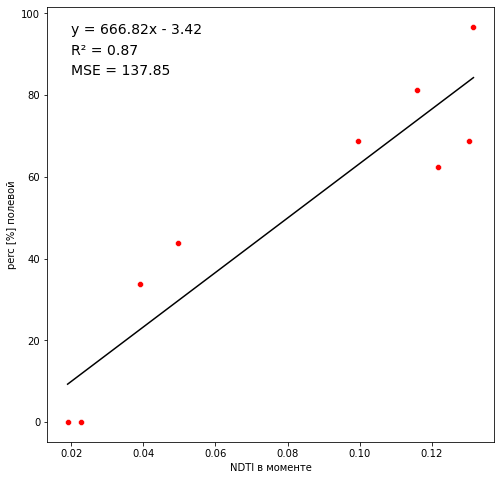

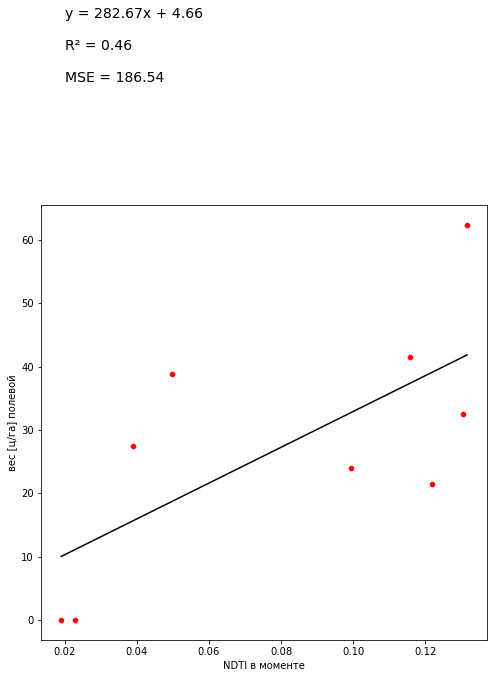

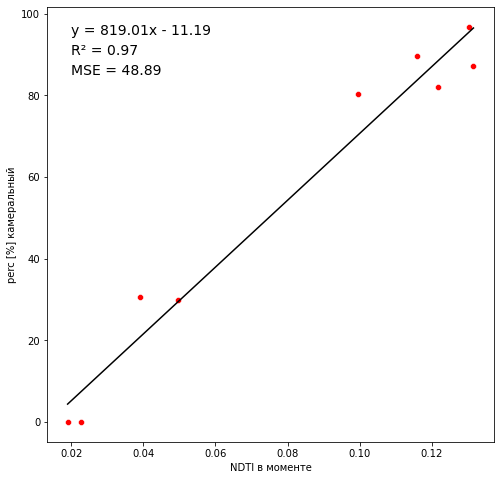

In [269]:
model1 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] полевой" ]])
model2 =  line_regression(archangelskiy[["NDTI в моменте","вес [ц/га] полевой" ]])
model3 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] камеральный" ]])

Text(0.02, 95, 'MSE = 378.33')

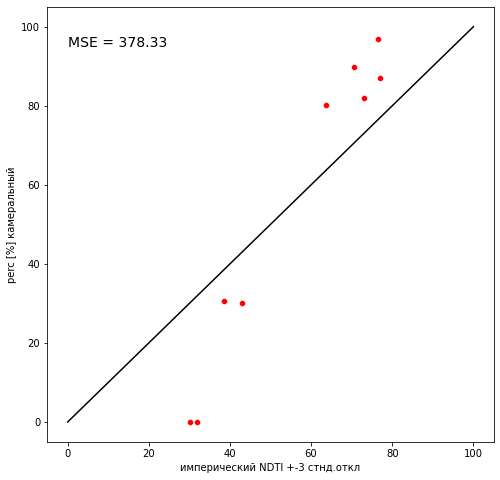

In [44]:
x = archangelskiy["имперический NDTI +-3 стнд.откл"] * 100
y = archangelskiy["perc [%] камеральный"]
mse = round(MSE(y, x), 2)

mse

fig , axes = plt.subplots(1,1, figsize=(8,8)) 

plot = sns.scatterplot(x = x, y = y, color = 'red', ax = axes)
plot = sns.lineplot(x = [0,10,20,30, 100], y = [0,10,20,30, 100], color = 'black', ax = axes)

axes.text(0.02, 95, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')


Text(0.02, 95, 'MSE = 294.56')

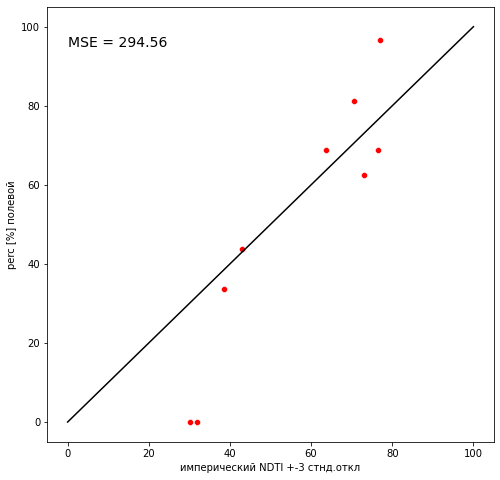

In [45]:
x = archangelskiy["имперический NDTI +-3 стнд.откл"] * 100
y = archangelskiy["perc [%] полевой"]
mse = round(MSE(y, x), 2)

mse

fig , axes = plt.subplots(1,1, figsize=(8,8)) 

plot = sns.scatterplot(x = x, y = y, color = 'red', ax = axes)
plot = sns.lineplot(x = [0,10,20,30, 100], y = [0,10,20,30, 100], color = 'black', ax = axes)

axes.text(0.02, 95, f"MSE = {mse}" , horizontalalignment='left', size=14, color='black')

In [50]:
rasters = listdir("raster_data/for_modeling")


In [49]:
for raster in rasters:
    file_name = "raster_data/for_modeling/" + raster
    raster_for_classify = rasterio.open(file_name) 


    metadata = raster_for_classify.meta
    metadata['count'] = 2

    raster_shape = raster_for_classify.read()[6].shape

    NDVI = raster_for_classify.read()[6]
    NDTI = raster_for_classify.read()[7]

    NDTI[NDVI >= 0.3] = 0 #создание маски для NDVI

    predicted = model3.predict(NDTI.reshape(-1, 1)).T
    CRC = predicted.reshape(raster_shape).astype('float32')
    CRC[CRC >= 100] = 100
    CRC[CRC <= 0] = 0


    ready_img = np.array([NDVI,CRC ])

    new_dataset = rasterio.open(f"raster_data/CRC/CRC{raster}", 'w', **metadata)
    new_dataset.write(ready_img)
    new_dataset.close()


IndexError: index 6 is out of bounds for axis 0 with size 1

In [299]:
CRC_rasters_dirs = listdir("raster_data/CRC")

archangelskiy_points_reprojected = archangelskiy_points.to_crs(metadata["crs"])
archangelskiy_points_reprojected.geometry =  archangelskiy_points_reprojected.buffer(distance  = 75)
def get_values(raster, geometry):
    """
    на вход растер (в данном случае канал 0 - NDVI  канал 1 - CRC)
    geometry - geopandas фаил где type - имя обьекта 
    """

    point_df = pd.DataFrame()
    date = raster.name.split("/")[-1]
    date = date.split('_')[3]

    unique_objects = geometry['type'].unique()
    for objects in unique_objects:

        litle_df = pd.DataFrame()
        geo = geometry[geometry['type'] == objects]
        arr, _ = mask(raster , shapes = geo.geometry.geometry, nodata=-10 )

        NDVI_arr = arr[0].reshape(-1) #массив NDVI
        NDVI_arr = NDVI_arr[NDVI_arr != -10]
        

        CRC_arr = arr[1].reshape(-1) #массив CRC 
        CRC_arr = CRC_arr[CRC_arr !=-10]
        

        
        litle_df['NDV_values'] = NDVI_arr
        litle_df['CRC_values'] = CRC_arr
        litle_df["date"] = date
        litle_df['type'] = objects
        litle_df = litle_df.sample(n = 10, random_state= 14)

        point_df = point_df.append(litle_df)
    
    return(point_df)


In [300]:
result_df = pd.DataFrame()
for rast  in CRC_rasters_dirs:
    raster_dir = "raster_data/CRC/" + rast
    raster = rasterio.open(raster_dir)
    one_date_df = get_values(raster , archangelskiy_points_reprojected)
    result_df = result_df.append(one_date_df)

result_df.to_csv('NDVI_CRC_by_buffered_points.csv', index = False)


In [197]:
result_df['date'] = pd.to_datetime(result_df['date'])

In [228]:
tree_fields = gpd.read_file('points_gps/3fields.geojson')

In [229]:
tree_fields = tree_fields.to_crs(metadata['crs'])

In [230]:
result_df = pd.DataFrame()
for rast  in CRC_rasters_dirs:
    raster_dir = "raster_data/CRC/" + rast
    raster = rasterio.open(raster_dir)
    one_date_df = get_values(raster , tree_fields)
    result_df = result_df.append(one_date_df)

result_df.to_csv('NDVI_CRC_by_fields.csv', index = False)

In [231]:
result_df = result_df.drop_duplicates()

In [233]:
preparing_df = result_df.copy()

In [238]:
preparing_df["CRC_values"][preparing_df['NDV_values'] > 0.3] = np.NaN

<ipython-input-238-c19fef812080>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preparing_df["CRC_values"][preparing_df['NDV_values'] > 0.3] = np.NaN


[(0.0, 100.0), Text(0, 0.5, 'CRC [%]'), Text(0.5, 0, '')]

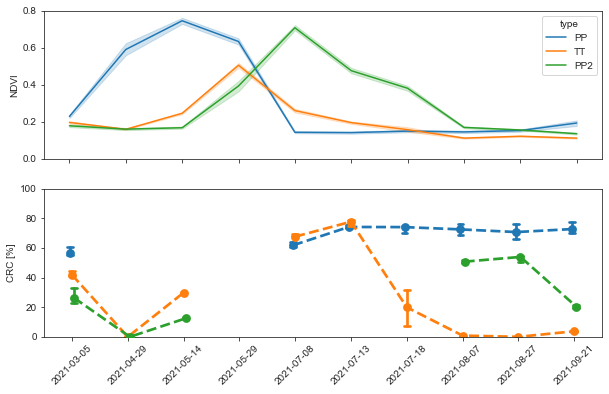

In [297]:
fig, ax = plt.subplots(2,1 , figsize=(10,6))

NDVI_plot = sns.lineplot(data = preparing_df , x = 'date', y = 'NDV_values',hue = 'type', ax = ax[0])
ax[0].set(ylim = (0 , 0.8), ylabel='NDVI',xlabel = "", xticklabels=[])


CRC_plot = sns.pointplot(data = preparing_df , x = 'date', y = 'CRC_values', hue = 'type',linestyles='--' , n_boot = 5, dodge=True, ci = 95, ax =  ax[1], capsize=.1, alpha = 0.5 )
CRC_plot.legend_.remove()
CRC_plot.set_xticklabels(CRC_plot.get_xticklabels(), rotation = 45)
ax[1].set(ylim = (0 , 100), ylabel='CRC [%]',xlabel = "")



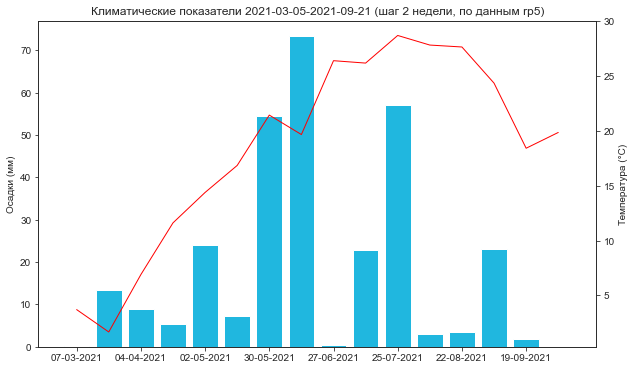

In [298]:
from visualisation_scripts import weather_visualisation
start = min(preparing_df.date)
finish = max(preparing_df.date)
weather_dir = "weather.csv"
weather = weather_visualisation(start , finish, weather_dir)

In [301]:
result_df

,NDV_values,CRC_values,date,type
15,0.213411,59.523228,2021-03-05,525
24,0.237366,54.820816,2021-03-05,525
73,0.241164,57.100746,2021-03-05,525
157,0.246079,59.246578,2021-03-05,525
119,0.214549,62.132931,2021-03-05,525
...,...,...,...,...
20,0.142342,22.747877,2021-09-21,588
108,0.135070,19.223539,2021-09-21,588
151,0.147041,23.137688,2021-09-21,588
54,0.147463,23.617939,2021-09-21,588


<ipython-input-337-6aa361ba3778>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_pp_points["CRC_values"][only_pp_points['NDV_values'] > 0.3] = np.NaN
C:\Users\User\Anaconda3\envs\gee\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


[(40.0, 100.0), Text(0, 0.5, 'CRC [%]'), Text(0.5, 0, '')]

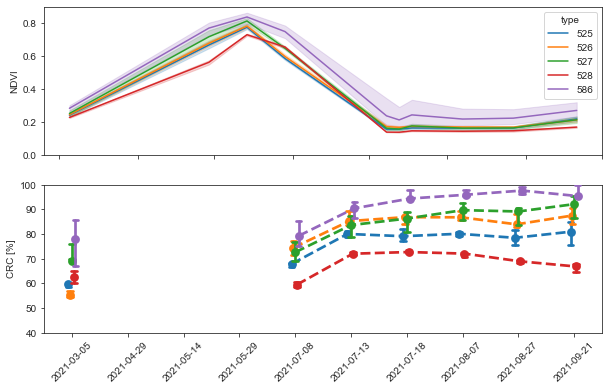

In [337]:
result_df['date'] = pd.to_datetime(result_df['date'],format = '%d.%m.%Y' )
PP_points = ['525', "526", '527', '528', "586"]
only_pp_points = result_df[result_df['type'].isin(PP_points)]
only_pp_points["CRC_values"][only_pp_points['NDV_values'] > 0.3] = np.NaN
fig, ax = plt.subplots(2,1 , figsize=(10,6))

NDVI_plot = sns.lineplot(data = only_pp_points , x = 'date', y = 'NDV_values',hue = 'type', ax = ax[0])
ax[0].set(ylim = (0 , 0.9), ylabel='NDVI',xlabel = "", xticklabels=[])


CRC_plot = sns.pointplot(data = only_pp_points , x = 'date', y = 'CRC_values', hue = 'type',linestyles='--' , n_boot = 5, dodge=True, ci = 95, ax =  ax[1], capsize=.1, alpha = 0.5 )
CRC_plot.legend_.remove()

date_labs = only_pp_points.date.dt.strftime('%Y-%m-%d').sort_values().unique()


ax[1].set_xticklabels(labels = date_labs, rotation = 45)
ax[1].set(ylim = (40 , 100), ylabel='CRC [%]',xlabel = "")

In [334]:
only_pp_points.date.dt.strftime('%Y-%m-%d').sort_values().unique()
#strftime('%Y-%m-%d').sort_values().unique()


array(['2021-03-05', '2021-04-29', '2021-05-14', '2021-05-29',
       '2021-07-08', '2021-07-13', '2021-07-18', '2021-08-07',
       '2021-08-27', '2021-09-21'], dtype=object)

In [316]:
PP_points = ['525', "526", '527', '528', "586"]

In [317]:
only_pp_points = result_df[result_df['type'].isin(PP_points)]
only_pp_points["CRC_values"][only_pp_points['NDV_values'] > 0.3] = np.NaN

<ipython-input-317-4245a29c08ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_pp_points["CRC_values"][only_pp_points['NDV_values'] > 0.3] = np.NaN
C:\Users\User\Anaconda3\envs\gee\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


[(0.0, 100.0), Text(0, 0.5, 'CRC [%]'), Text(0.5, 0, '')]

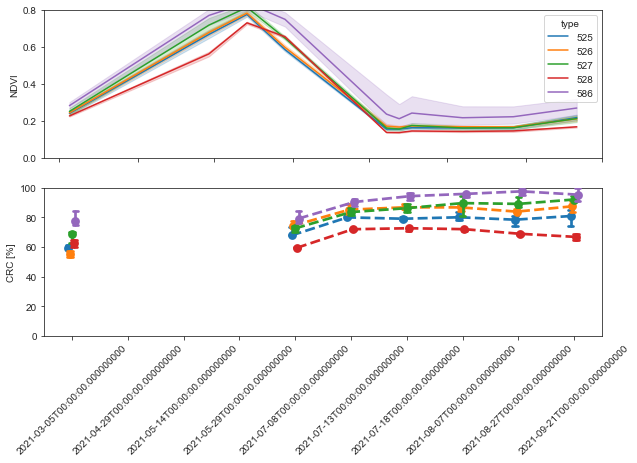

In [318]:
fig, ax = plt.subplots(2,1 , figsize=(10,6))

NDVI_plot = sns.lineplot(data = only_pp_points , x = 'date', y = 'NDV_values',hue = 'type', ax = ax[0])
ax[0].set(ylim = (0 , 0.8), ylabel='NDVI',xlabel = "", xticklabels=[])


CRC_plot = sns.pointplot(data = only_pp_points , x = 'date', y = 'CRC_values', hue = 'type',linestyles='--' , n_boot = 5, dodge=True, ci = 95, ax =  ax[1], capsize=.1, alpha = 0.5 )
CRC_plot.legend_.remove()
CRC_plot.set_xticklabels(CRC_plot.get_xticklabels(), rotation = 45)
ax[1].set(ylim = (0 , 100), ylabel='CRC [%]',xlabel = "")


In [322]:
CRC_plot.get_xticklabels()

[Text(0, 0, '2021-03-05T00:00:00.000000000'),
 Text(1, 0, '2021-04-29T00:00:00.000000000'),
 Text(2, 0, '2021-05-14T00:00:00.000000000'),
 Text(3, 0, '2021-05-29T00:00:00.000000000'),
 Text(4, 0, '2021-07-08T00:00:00.000000000'),
 Text(5, 0, '2021-07-13T00:00:00.000000000'),
 Text(6, 0, '2021-07-18T00:00:00.000000000'),
 Text(7, 0, '2021-08-07T00:00:00.000000000'),
 Text(8, 0, '2021-08-27T00:00:00.000000000'),
 Text(9, 0, '2021-09-21T00:00:00.000000000')]